# Visualization of Clusters within PCA Feature Space

This notebook visualizes the clusters in the PCA feature space, resamples the DEM to match Sentinel-2 resolution, and creates a DataFrame with all variables for subsequent analyses.

Author: Javier Lopatin  
Date: 2025-11-10  
Version: 1.0

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rio
import seaborn as sns

In [2]:
inputData = 'KernelPCA_clip'
n_clusters = 9
clusters = rio.open_rasterio('Rasters/kmenas_'+inputData+'_'+str(n_clusters)+'.tif')
pca      = rio.open_rasterio('Rasters/'+inputData+'.tif')
#pca      = rio.open_rasterio('Rasters/rmseAll.tif')
#clusters = rio.open_rasterio('Rasters/kmenas_autoencoders_3.tif')
#pca      = rio.open_rasterio('Rasters/autoencoders.tif')

In [3]:
# 3D xarray to 2D xarray
def _flatted(x):
    x = x.stack(z=('y','x'))
    return  x.transpose('z', 'band')

cluster_flat = _flatted(clusters)
pca_flat     = _flatted(pca)

# get index of rows with nodata in cluster_flat
no_data = cluster_flat.isnull().any(axis=1)

# if cluster_flat.shape not equal to pca_flat.shape, reproject pca_flat
if cluster_flat.shape != pca_flat.shape:
    pca = pca.rio.reproject_match(clusters)
    cluster_flat = _flatted(clusters)
    pca_flat     = _flatted(pca)

# select rows with no data in cluster_flat
cluster_flat = cluster_flat[~no_data]

# select same rows in pca_flat
pca_flat = pca_flat[~no_data]

print('the shape of the cluster is   ', cluster_flat.shape)
print('the shape of the predictor is ', pca_flat.shape)

the shape of the cluster is    (2616556, 1)
the shape of the predictor is  (2616556, 3)


In [13]:
# merge cluster_flat and pca_flat using numpy
df = np.concatenate((cluster_flat.values, pca_flat.values), axis=1)

# df to pandas dataframe
df_pd = pd.DataFrame(df)
# add column names
df_pd.columns = ['cluster', 'PC1', 'PC2',  'PC3']#['cluster', *pca.attrs['long_name']]
df_pd.head()

,cluster,PC1,PC2,PC3
0,8.0,-0.081573,0.490087,-0.251238
1,8.0,0.005605,0.534242,-0.200795
2,7.0,0.356986,0.402072,-0.229198
3,8.0,0.340557,0.427056,-0.185704
4,8.0,0.279248,0.468944,-0.207226


In [ ]:
# save df_pd to csv
df_pd.to_csv('data/clusters_'+inputData+'_'+str(n_clusters)+'.csv', index=False)

### Plot clusters inside PCA feature-space

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cluster_kde(df, xaxis, yaxis):
    # select 5000 random rows from df
    df_random = df.sample(n=5000, random_state=1)
    col = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6'] # 9 classes
    #col = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#bf5b17'] # 7 classes
    
    # increase font size, keep default style
    sns.set(font_scale=1.2, style="white")
    
    # Create a jointplot with gray scatterplot background
    g = sns.JointGrid(data=df_random, x=xaxis, y=yaxis)

    # Add scatterplot as background
    g.plot_joint(sns.scatterplot, color="gray", alpha=0.15)

    # Add KDE plot on top of the scatterplot
    sns.kdeplot(data=df_random, x=xaxis, y=yaxis, hue="cluster", palette=col, linewidths=2, fill=False, zorder=2, ax=g.ax_joint)

    # Function to plot marginal KDEs for clusters
    def plot_cluster_kde(x, data, hue, palette, ax, vertical=False):
        for cluster, color in zip(data[hue].unique(), palette):
            cluster_data = data[data[hue] == cluster]
            sns.kdeplot(x=x, data=cluster_data, color=color, linewidth=2, ax=ax, vertical=vertical)

    # Add KDE plots for cluster values at the marginals
    plot_cluster_kde(x=xaxis, data=df_random, hue="cluster", palette=col, ax=g.ax_marg_x)
    plot_cluster_kde(x=yaxis, data=df_random, hue="cluster", palette=col, ax=g.ax_marg_y, vertical=True)

    # Set the same scale for both axes with added space
    x_range = df_random[xaxis].max() - df_random[xaxis].min()
    y_range = df_random[yaxis].max() - df_random[yaxis].min()
    x_margin = 0.1 * x_range
    y_margin = 0.1 * y_range
    g.ax_joint.set_xlim(df_random[xaxis].min() - x_margin, df_random[xaxis].max() + x_margin)
    g.ax_joint.set_ylim(df_random[yaxis].min() - y_margin, df_random[yaxis].max() + y_margin)

    # add dashed vertical and horizontal lines in zero interception
    g.ax_joint.axvline(x=0, color='black', linestyle='--', linewidth=1)
    g.ax_joint.axhline(y=0, color='black', linestyle='--', linewidth=1)

/home/javier/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/tmp/ipykernel_16137/4204634336.py:26: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `x`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(x=x, data=cluster_data, color=color, linewidth=2, ax=ax, vertical=vertical)
/tmp/ipykernel_16137/4204634336.py:26: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `x`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(x=x, data=cluster_data, color=color, linewidth=2, ax=ax, vertical=vertical)
/tmp/ipykernel_16137/4204634336.py:26: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `x`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(x=x, data=cluster_data, color=color, linewidth=2, ax=ax, vertical=ve

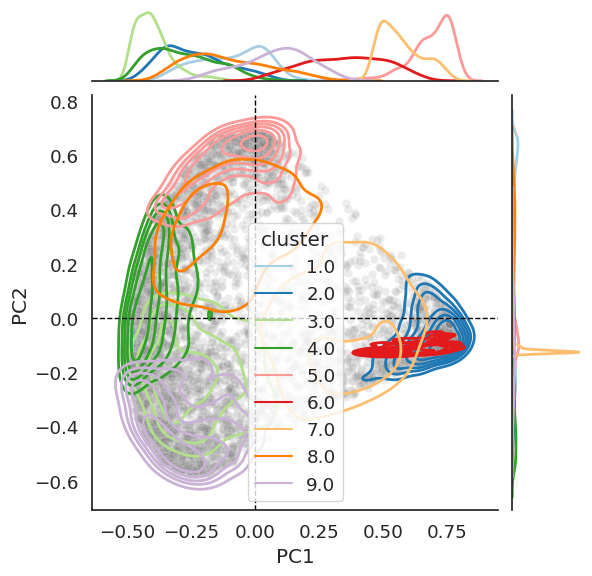

In [35]:
plot_cluster_kde(df_pd, "PC1", "PC2")

plt.savefig('figures/clusters'+'_'+inputData+'_'+str(n_clusters)+'_PC1_2.svg')

/tmp/ipykernel_16137/4204634336.py:26: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `x`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(x=x, data=cluster_data, color=color, linewidth=2, ax=ax, vertical=vertical)
/tmp/ipykernel_16137/4204634336.py:26: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `x`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(x=x, data=cluster_data, color=color, linewidth=2, ax=ax, vertical=vertical)
/tmp/ipykernel_16137/4204634336.py:26: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `x`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(x=x, data=cluster_data, color=color, linewidth=2, ax=ax, vertical=vertical)
/tmp/ipykernel_16137/4204634336.py:26: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `x`.
This will become an error in seaborn v0.13.0; 

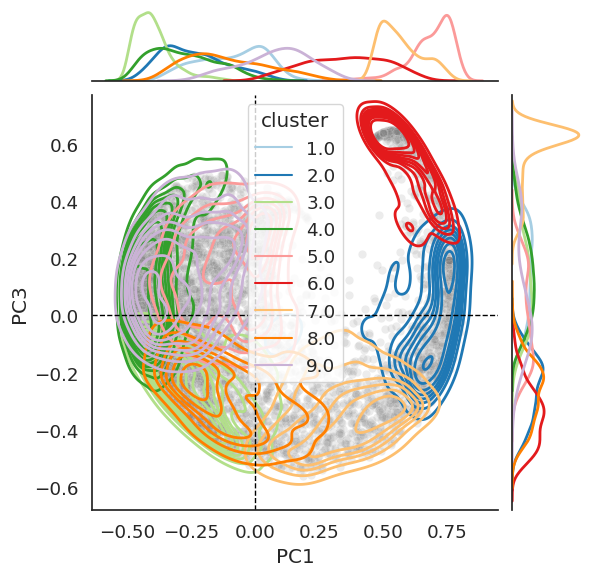

In [36]:
plot_cluster_kde(df_pd, "PC1", "PC3")
plt.savefig('figures/clusters'+'_'+inputData+'_'+str(n_clusters)+'_PC1_3.svg')

/home/javier/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/tmp/ipykernel_16137/4204634336.py:26: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `x`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(x=x, data=cluster_data, color=color, linewidth=2, ax=ax, vertical=vertical)
/tmp/ipykernel_16137/4204634336.py:26: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `x`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(x=x, data=cluster_data, color=color, linewidth=2, ax=ax, vertical=vertical)
/tmp/ipykernel_16137/4204634336.py:26: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `x`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(x=x, data=cluster_data, color=color, linewidth=2, ax=ax, vertical=ve

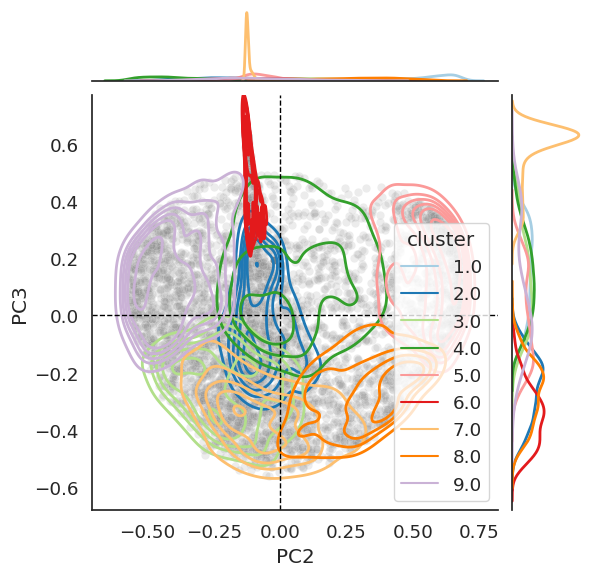

In [37]:
plot_cluster_kde(df_pd, "PC2", "PC3")
plt.savefig('figures/clusters'+'_'+inputData+'_'+str(n_clusters)+'_PC2_3.svg')

### Rasterize shapfile with PFT information

In [37]:
gdf = gpd.read_file("SHP/Suisun_PFT_diss_proj.shp")

# mask Agriculture and Urban from PFT
gdf = gdf[gdf['PFT'] != 'Agriculture']
gdf = gdf[gdf['PFT'] != 'Urban or developed']

# add new column to gdf with unique values from PFT
gdf['PFT_num'] = gdf['PFT'].astype('category').cat.codes
gdf['PFT_num']

1     0
2     1
3     2
4     3
5     4
6     5
8     6
9     7
10    8
Name: PFT_num, dtype: int8

In [38]:
# show gdf['PFT'] and gdf['PFT_num'] side by side
id_names = pd.concat([gdf['PFT'], gdf['PFT_num']], axis=1)
id_names

,PFT,PFT_num
1,Annual Grassland,0
2,Barren,1
3,Other,2
4,Perennial Grassland,3
5,Pickleweed-Cordgrass-Saltbush,4
6,Tule-Cattail,5
8,Water,6
9,Wet Meadows,7
10,Willow,8


In [64]:
# save gdf to disk
gdf.to_file("SHP/Suisun_PFT_diss_proj_num.shp")

In [65]:
# rasterize shapefile of PFT classes usin geocube
from geocube.api.core import make_geocube

out_grid = make_geocube(
    vector_data="SHP/Suisun_PFT_diss_proj_num.shp",
    measurements=["PFT_num"],
    resolution=(-10, 10),
)
out_grid#["PFT_num"].rio.to_raster("Rasters/PFT.tif")

<xarray.Dataset>
Dimensions:      (y: 2308, x: 2523)
Coordinates:
  * y            (y) float64 4.234e+06 4.234e+06 4.233e+06 ... 4.21e+06 4.21e+06
  * x            (x) float64 5.756e+05 5.757e+05 ... 6.009e+05 6.009e+05
    spatial_ref  int64 0
Data variables:
    PFT_num      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [ ]:
# resample size of out_grid using cluster raster
out_grid = out_grid.PFT_num.rio.reproject_match(clusters)
out_grid.rio.to_raster("Rasters/PFT.tif")

### DEM t0 10 m


In [11]:
!gdalinfo Rasters/kmenas_KernelPCA_clip_9.tif

Driver: GTiff/GeoTIFF
Files: Rasters/kmenas_KernelPCA_clip_9.tif
       Rasters/kmenas_KernelPCA_clip_9.tif.aux.xml
Size is 2530, 2243
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
    

In [39]:
!gdalwarp -overwrite -tr 10 -10 -te 575570 4211380 600870 4233810 -r near -of GTiff Rasters/dem.tif Rasters/dem_10m.tif

Creating output file that is 2530P x 2243L.
Processing Rasters/dem.tif [1/1] : 0Using internal nodata values (e.g. -3.4e+38) for image Rasters/dem.tif.
Copying nodata values from source Rasters/dem.tif to destination Rasters/dem_10m.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [9]:
# check output using tuiview interactive window 
!tuiview Rasters/dem_10m.tif

### Funtion to fattened rasters into dataframes

In [12]:
# 3D xarray to 2D xarray
def flattened_data(dir, col_name):
    # open shapefile
    shp = gpd.read_file('SHP/Suisun_PFT_diss.shp')
    # mask Agriculture and Urban from PFT
    shp = shp[shp['PFT'] != 'Agriculture']
    shp = shp[shp['PFT'] != 'Urban or developed']

    # load raster
    x = rio.open_rasterio(dir)
    # mask raster with shapefile
    x = x.rio.clip(shp.geometry, shp.crs)
    x = x.stack(z=('y','x'))
    x = x.transpose('z', 'band')
    # get index of rows with no data in cluster_flat
    no_data = x.isnull().any(axis=1)
    
    # convert to pandas DataFrame
    df = pd.DataFrame(x[~no_data].values, columns=x.band.values)
    # rename columns
    df.columns = col_name
   
    return df


In [13]:
# flatten out_grid

# PFT
pft_flat = flattened_data('Rasters/PFT.tif', ['PFT'])

# Cluster
cluster_flat = flattened_data('Rasters/kmenas_'+inputData+'_'+str(n_clusters)+'.tif', ['cluster'])

# Phenology
xnew = np.linspace(5, 360, 52, dtype='int16')
bandNames = []
for i in range(52):
    a = "DOY_" + str(xnew[i])
    bandNames.append(a)
pheno_flat = flattened_data('Rasters/phenoshapeAll.tif', bandNames)

# LSP
LSPbands = ['SOS', 'POS', 'EOS', 'vSOS', 'vPOS', 'vEOS', 'LOS', 'MSP', 'MAU',
            'vMSP', 'vMAU', 'AOS', 'IOS', 'ROG', 'ROS', 'SW']

lsp_flat = flattened_data('Rasters/lspAll.tif', LSPbands)

rmse_flat = flattened_data('Rasters/rmseAll.tif', ['rmse_all', 'rmse_sos', 'rmse_pos', 'rmse_eos'])

# DEM
dem_flat = flattened_data('Rasters/dem_10m.tif', ['elevation'])



In [14]:
# merge cluster_flat and out_grid_flat using numpy
df = pd.concat([pft_flat, cluster_flat, pheno_flat, lsp_flat, rmse_flat, dem_flat], axis=1)

df.head()

,PFT,cluster,DOY_5,DOY_11,DOY_18,DOY_25,DOY_32,DOY_39,DOY_46,DOY_53,...,AOS,IOS,ROG,ROS,SW,rmse_all,rmse_sos,rmse_pos,rmse_eos,elevation
0,6.0,3.0,0.381691,0.510388,0.735784,0.781345,0.860137,0.826960,0.742031,0.702689,...,0.698340,119.959808,0.005165,-0.004658,0.212369,0.009491,0.009254,0.007918,0.005008,-3.400000e+38
1,6.0,3.0,1.076724,1.076724,1.081043,0.965716,0.924420,0.801081,0.707058,0.689719,...,0.686780,109.468153,0.000617,-0.003909,-0.086745,0.009444,0.009444,0.008125,0.005486,-3.400000e+38
2,6.0,1.0,0.294468,0.374028,0.670980,0.726225,0.811330,0.762278,0.640738,0.583429,...,0.578449,82.174437,0.020824,-0.003829,-0.399038,0.007352,0.007341,0.006640,0.005227,-3.400000e+38
3,6.0,3.0,0.286049,0.393415,0.756189,0.813442,0.917994,0.848960,0.698541,0.617153,...,0.704146,84.181732,0.024980,-0.005324,-0.753242,0.008461,0.008447,0.007693,0.006172,-3.400000e+38
4,6.0,3.0,0.240742,0.461404,0.782395,0.851344,0.930415,0.848045,0.698713,0.648436,...,0.722507,80.851771,0.002743,-0.005584,0.249405,0.008161,0.007474,0.007388,0.006529,-3.400000e+38


In [ ]:
df.to_csv('data/All_variables_9.csv', index=False)